In [1]:
import altair as alt
import os
import pandas as pd
import scipy.io

from simulation_viz.simulation_viz.import_simulation_data import load_simulation, get_time_series_quantiles
from simulation_viz.simulation_viz.check_simulations import check_for_negative_concentrations, get_non_converging_models, remove_models
from simulation_viz.simulation_viz.visualize_simulations import plot_ensemble, plot_model
from simulation_viz.simulation_viz.visualize_simulations_interactive import plot_ensemble_interactive, plot_model_interactive
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

### Define path to the folder that contains the simulation results and model ensemble

In [2]:
raw_data_dir = '../io/output'

### Define the model name

In [3]:
model_name = 'toy_model'

### Define the simulation name

In [4]:
simulation_name = 'toy_model'

### Define number of models to be simulated

In [5]:
n_models = 5

### Load and process data

In [6]:
conc, flux, met_names, rxn_names = load_simulation(raw_data_dir, model_name, simulation_name, n_models)

total time: 0.01587367057800293
There were a total of 0 missing models out of 5.


### Check and filter out models

Check for negative concentrations

In [7]:
check_for_negative_concentrations(conc, scaled=False)

All concentrations are above the treshold -1e-08 :)


Check for non converging models

In [8]:
non_converging_models = get_non_converging_models(conc, n_models, met_names, rel_tol=5*10**-3)
non_converging_models

[2]

Remove non-converging models

In [9]:
conc_filtered, flux_filtered = remove_models(conc, flux, non_converging_models)   

### Aggregate simulation results into median, 1st and 3rd quartile

In [10]:
quant_type = 'conc_abs'
conc_interp_quantiles = get_time_series_quantiles(conc_filtered, quant_type, met_names)
    
quant_type = 'flux_abs'
flux_interp_quantiles = get_time_series_quantiles(flux_filtered, quant_type, rxn_names)

### Plot results with matplotlib

To plot absolute concentrations set quant_type='conc_abs', to plot relative concentrations set quant_type='conc_rel'.

To plot absolute fluxes set quant_type='flux_abs', to plot relative fluxes set quant_type='flux_rel'.

#### Plot results for a given model

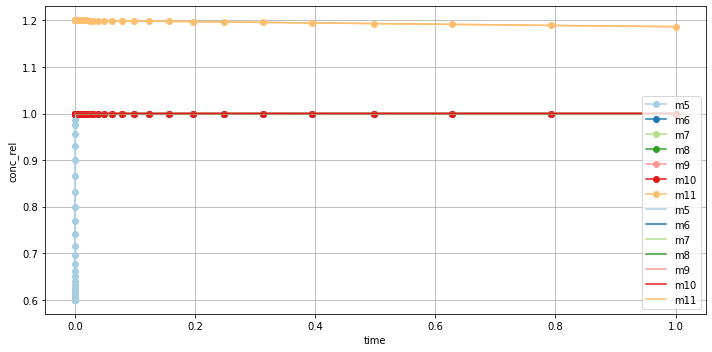

In [11]:
plot_model(conc, model_i=1, quant_type='conc_rel',
           selected_data=met_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

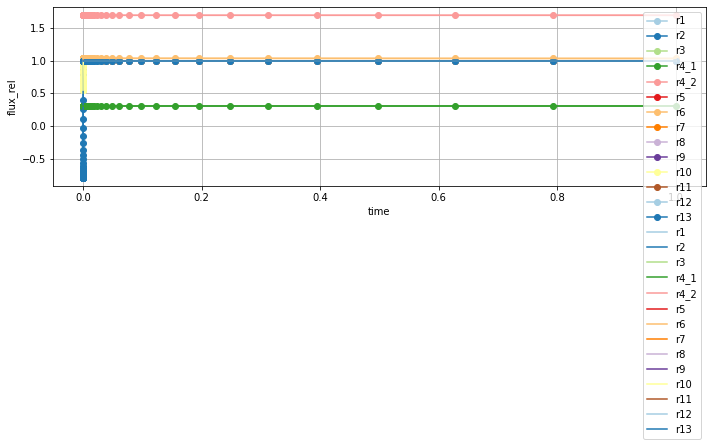

In [12]:
plot_model(flux, model_i=1, quant_type='flux_rel',
           selected_data=rxn_names,  x_scale='linear', y_scale='linear', x_lim=None,
            y_lim=None, fig_size=None, save_plot=False, output_file=None)

#### Plot summarized results for whole ensemble

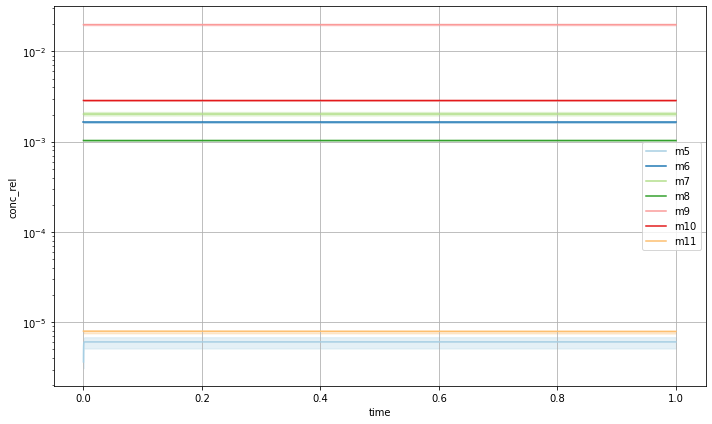

In [13]:
x_lim = None
y_lim = None

plot_ensemble(conc_interp_quantiles, quant_type='conc_rel', selected_data=[met_names], x_scale='linear',
              y_scale='log', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

/home/mrama/GRASP_test/GRASP/visualization/simulation_viz/simulation_viz/visualize_simulations.py:70: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale(y_scale)


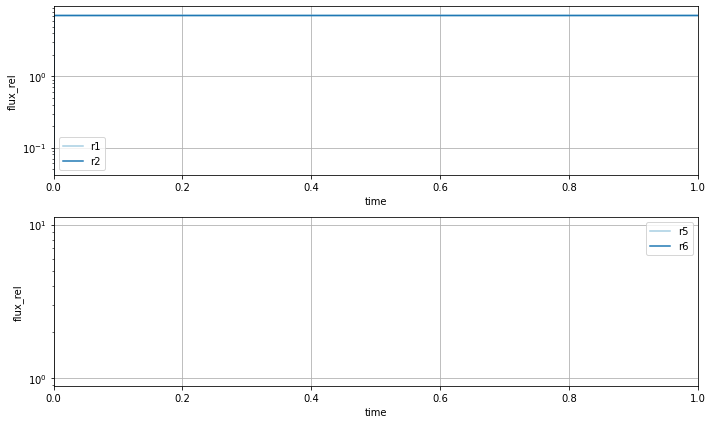

In [14]:
x_lim = [0, 1]
y_lim = None

plot_ensemble(flux_interp_quantiles, quant_type='flux_rel', selected_data=[['r1', 'r2'], ['r5', 'r6']], x_scale='linear',
              y_scale='log', x_lim=x_lim, y_lim=y_lim, fig_size=(10,6), save_plot=False, output_file=None)

### Plot results with altair

To plot absolute concentrations set quant_type='conc_abs', to plot relative concentrations set quant_type='conc_rel'.

To plot absolute fluxes set quant_type='flux_abs', to plot relative fluxes set quant_type='flux_rel'.

#### Plot results for a given model

In [15]:
plot_model_interactive(conc, model_i=2, quant_type='conc_abs',
                       selected_data=met_names, x_scale='linear',
                       y_scale='log', x_lim=[0,1], y_lim=None)

alt.LayerChart(...)

In [16]:
plot_model_interactive(flux, model_i=2, quant_type='flux_abs',
                       selected_data=rxn_names, x_scale='linear',
                       y_scale='linear', x_lim=[0,1], y_lim=None)

alt.LayerChart(...)

#### Plot summarized results for whole ensemble

In [17]:
plot_ensemble_interactive(conc_interp_quantiles, quant_type='conc_abs', selected_data=met_names, x_scale='linear',
                          y_scale='log', x_lim=None, y_lim=None)

alt.LayerChart(...)

In [18]:
plot_ensemble_interactive(flux_interp_quantiles, quant_type='flux_abs', selected_data=rxn_names, x_scale='linear',
                          y_scale='linear', x_lim=None, y_lim=None)

alt.LayerChart(...)